# Step 3: Semantic Layout Graph Visualization

This notebook demonstrates how to visualize the semantic layout graphs built from DocVQA documents.

**Features:**
- Load OCR results and layout regions
- Build semantic layout graph with spatial and semantic relations
- Visualize graph structure with nodes and edges
- Display detailed statistics and relation types

## 1. Import Required Libraries

In [1]:
import sys
import os
from pathlib import Path
import json
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch, Rectangle

# Add project root to path
sys.path.insert(0, '..')
import pathlib
PROJECT_ROOT = pathlib.Path().resolve().parents[1]
sys.path.append(str(PROJECT_ROOT))

# Import our modules
from src.graph.graph_builder import GraphBuilder
from src.ocr.ocr_processor import PaddleOCRProcessor
from src.ocr.layout_analyzer import DocumentLayoutAnalyzer
from src.ocr.layout import *

print("✅ All libraries imported successfully!")

Input folder: /mnt/e/DocVQA/dataset/DocVQA_Images
Output folder: /mnt/e/DocVQA/dataset/DocVQA_OCR
✅ All libraries imported successfully!


## 1.5. Token Classification Test (NEW)

Demo token classifier - phân loại OCR tokens theo semantic type trước khi grouping.

In [2]:
from src.ocr.token_classifier import TokenClassifier

# Initialize token classifier
token_classifier = TokenClassifier()

# Sample invoice-like tokens
invoice_tokens = [
    {'text': 'INVOICE', 'bbox': [100, 50, 200, 80]},
    {'text': 'Number:', 'bbox': [50, 120, 120, 140]},
    {'text': 'INV-2024-001', 'bbox': [130, 120, 250, 140]},
    {'text': 'Date:', 'bbox': [50, 160, 100, 180]},
    {'text': '12/01/2024', 'bbox': [110, 160, 200, 180]},
    {'text': 'Customer:', 'bbox': [50, 200, 130, 220]},
    {'text': 'ABC Corporation', 'bbox': [140, 200, 280, 220]},
    {'text': 'Amount:', 'bbox': [50, 240, 120, 260]},
    {'text': '$1,234.56', 'bbox': [130, 240, 220, 260]},
    {'text': 'Description:', 'bbox': [50, 280, 150, 300]},
    {'text': 'Consulting services for Q1 2024', 'bbox': [160, 280, 400, 300]},
]

# Classify tokens
classified = token_classifier.classify_tokens(invoice_tokens)

# Display results
print("="*80)
print("TOKEN CLASSIFICATION RESULTS")
print("="*80)
print(f"{'Text':40} {'Type':15}")
print("-"*80)

for token in classified:
    text = token['text'][:35] + '...' if len(token['text']) > 35 else token['text']
    print(f"{text:40} {token['token_type']:15}")

# Show statistics
stats = token_classifier.get_statistics(classified)
print("\n" + "="*80)
print("STATISTICS")
print("="*80)
for token_type, count in sorted(stats.items(), key=lambda x: x[1], reverse=True):
    print(f"{token_type:20}: {count}")
print("="*80)

print("\n✅ Token classification successfully integrated into pipeline!")

TOKEN CLASSIFICATION RESULTS
Text                                     Type           
--------------------------------------------------------------------------------
INVOICE                                  text           
Number:                                  form_key       
INV-2024-001                             text           
Date:                                    form_key       
12/01/2024                               form_value     
Customer:                                form_key       
ABC Corporation                          text           
Amount:                                  form_key       
$1,234.56                                form_value     
Description:                             form_key       
Consulting services for Q1 2024          text           

STATISTICS
form_key            : 5
text                : 4
form_value          : 2

✅ Token classification successfully integrated into pipeline!


## 2. Configuration and Setup

In [3]:
# Configure graph builder (pass parameters directly, no GraphConfig class)
graph_builder = GraphBuilder(
    iou_threshold=0.1,
    distance_threshold=200.0,
    projection_threshold=0.3,
    max_neighbors=5,
    min_edge_score=0.2
)

# Color scheme for different region types
REGION_COLORS = {
    'TextBlock': '#3498db',  # Blue
    'Table': '#e74c3c',      # Red
    'Figure': '#2ecc71',     # Green
    'Form': '#f39c12'        # Orange
}

# Color scheme for relation types
RELATION_COLORS = {
    'left_of': '#9b59b6',
    'right_of': '#e91e63',
    'above': '#3f51b5',
    'below': '#00bcd4',
    'inside': '#4caf50',
    'contains': '#8bc34a',
    'nearest_neighbor': '#ff9800',
    'is_caption_of': '#ff5722',
    'has_caption': '#f44336',
    'explains': '#795548',
    'has_explanation': '#607d8b'
}

print("✅ Configuration set!")

✅ Configuration set!


## 3. Load Sample Data or Create Demo Regions

You can either:
- Load regions from JSON file (from previous OCR + Layout analysis)
- Create demo regions manually for testing

In [4]:
### Option A: Load from JSON file (for real OCR results)
def load_regions_from_json(json_path):
    """Load regions from OCR output JSON"""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    regions = []
    if 'layout' in data and 'regions' in data['layout']:
        regions = data['layout']['regions']
    elif 'regions' in data:
        regions = data['regions']
    
    print(f"✅ Loaded {len(regions)} regions from {json_path}")
    return regions


### Option B: Create demo regions (format matching GraphBuilder expectations)
def create_demo_regions():
    """
    Create sample regions in the format expected by GraphBuilder:
    
    Each region must have:
    - 'region_type': 'TextBlock', 'Table', 'Figure', 'Form'
    - 'block': {'bbox': [[x1,y1], [x2,y2], [x3,y3], [x4,y4]], 'lines': [...]}
    - 'score': confidence score
    """
    regions = [
        {
            'region_type': 'TextBlock',
            'block': {
                'bbox': [[50, 50], [300, 50], [300, 100], [50, 100]],
                'lines': [{'text': 'Document Title: Annual Report 2024'}]
            },
            'score': 0.95
        },
        {
            'region_type': 'TextBlock',
            'block': {
                'bbox': [[50, 120], [200, 120], [200, 160], [50, 160]],
                'lines': [{'text': 'Table 1: Quarterly Sales Figures'}]
            },
            'score': 0.92
        },
        {
            'region_type': 'Table',
            'block': {
                'bbox': [[50, 180], [350, 180], [350, 350], [50, 350]],
                'lines': [{'text': 'Q1: $1.2M | Q2: $1.5M | Q3: $1.8M | Q4: $2.1M'}]
            },
            'score': 0.88
        },
        {
            'region_type': 'TextBlock',
            'block': {
                'bbox': [[400, 50], [550, 50], [550, 100], [400, 100]],
                'lines': [{'text': 'Figure 1: Sales Growth Chart'}]
            },
            'score': 0.90
        },
        {
            'region_type': 'Figure',
            'block': {
                'bbox': [[400, 120], [650, 120], [650, 350], [400, 350]],
                'lines': [{'text': '[Chart Image]'}]
            },
            'score': 0.85
        },
        {
            'region_type': 'TextBlock',
            'block': {
                'bbox': [[50, 380], [650, 380], [650, 450], [50, 450]],
                'lines': [{'text': 'The sales figures show consistent growth across all quarters...'}]
            },
            'score': 0.93
        }
    ]
    
    print(f"✅ Created {len(regions)} demo regions")
    return regions


def convert_bbox_to_xyxy(bbox):
    """Convert 4-point bbox to [x1, y1, x2, y2] format for visualization"""
    x_coords = [p[0] for p in bbox]
    y_coords = [p[1] for p in bbox]
    return [min(x_coords), min(y_coords), max(x_coords), max(y_coords)]


# Choose one option:
# regions = load_regions_from_json('path/to/ocr_output.json')
regions = create_demo_regions()

✅ Created 6 demo regions


## 4. Build Semantic Layout Graph

In [5]:
# Build the graph - returns a Dict with 'nodes', 'edges', 'adjacency'
graph_result = graph_builder.build_graph(regions)

# Extract components
nodes = graph_result['nodes']
edges = graph_result['edges']
adjacency = graph_result['adjacency']

print(f"\n{'='*60}")
print(f"📊 GRAPH BUILDING RESULTS")
print(f"{'='*60}")
print(f"Total Nodes: {len(nodes)}")
print(f"Total Edges: {len(edges)}")
print(f"\nEdges by Relation Type:")
print(f"-" * 60)

# Group edges by relation type
relation_counts = {}
for edge in edges:
    rel_type = edge['relation']
    relation_counts[rel_type] = relation_counts.get(rel_type, 0) + 1

for rel_type, count in sorted(relation_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {rel_type:20s}: {count:3d} edges")

print(f"\nEdges by Category:")
print(f"-" * 60)
category_counts = {}
for edge in edges:
    cat = edge.get('category', 'unknown')
    category_counts[cat] = category_counts.get(cat, 0) + 1

for cat, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {cat:15s}: {count:3d} edges")

print(f"{'='*60}\n")


📊 GRAPH BUILDING RESULTS
Total Nodes: 6
Total Edges: 27

Edges by Relation Type:
------------------------------------------------------------
  above               :   9 edges
  below               :   9 edges
  left_of             :   3 edges
  nearest_neighbor    :   3 edges
  right_of            :   3 edges

Edges by Category:
------------------------------------------------------------
  spatial        :  24 edges
  proximity      :   3 edges



## 5. Visualize Graph Structure

### 5.1 Basic Graph Visualization - Nodes and Edges

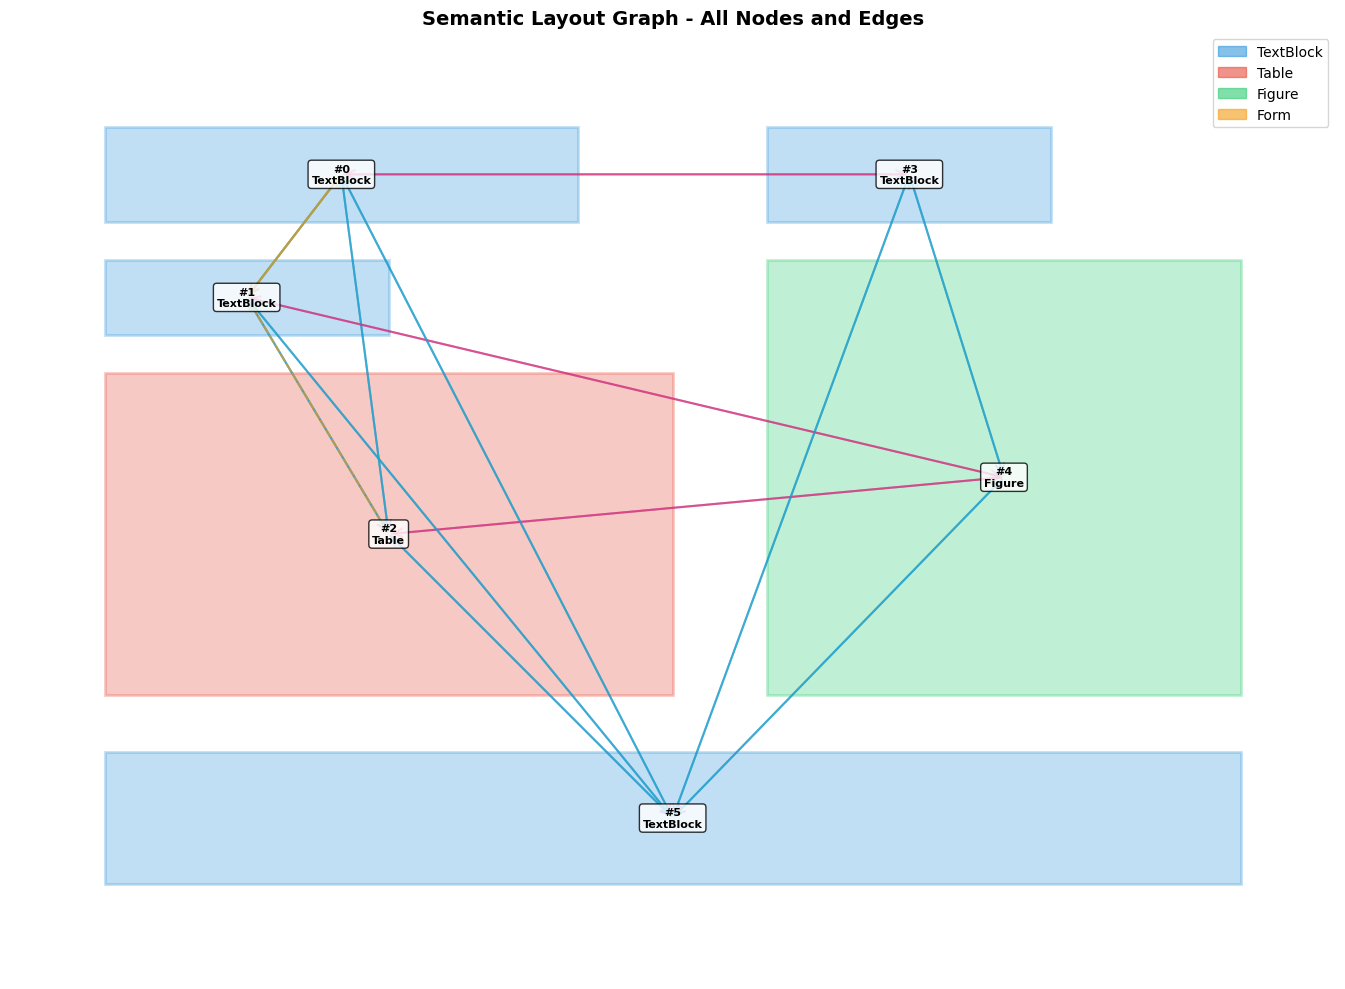

In [6]:
def visualize_graph_basic(nodes, edges, figsize=(14, 10)):
    """
    Visualize the graph with all nodes (bboxes) and edges (arrows)
    
    Args:
        nodes: List of node dicts from graph_result['nodes']
        edges: List of edge dicts from graph_result['edges']
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate canvas size from node bboxes
    max_x = max_y = 0
    for node in nodes:
        bbox = node['bbox']  # 4-point format [[x1,y1], ...]
        x_coords = [p[0] for p in bbox]
        y_coords = [p[1] for p in bbox]
        max_x = max(max_x, max(x_coords))
        max_y = max(max_y, max(y_coords))
    
    ax.set_xlim(0, max_x + 50)
    ax.set_ylim(max_y + 50, 0)  # Invert y-axis (image coordinates)
    
    # Draw nodes (regions)
    for node in nodes:
        bbox = node['bbox']  # 4-point format
        x_coords = [p[0] for p in bbox]
        y_coords = [p[1] for p in bbox]
        x1, y1 = min(x_coords), min(y_coords)
        x2, y2 = max(x_coords), max(y_coords)
        width = x2 - x1
        height = y2 - y1
        
        color = REGION_COLORS.get(node['region_type'], '#95a5a6')
        
        # Draw rectangle
        rect = Rectangle((x1, y1), width, height, 
                         linewidth=2, edgecolor=color, 
                         facecolor=color, alpha=0.3)
        ax.add_patch(rect)
        
        # Add node label
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        ax.text(center_x, center_y, f"#{node['node_id']}\n{node['region_type']}", 
               ha='center', va='center', fontsize=8, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Draw edges
    for edge in edges:
        src_idx = edge['source']
        tgt_idx = edge['target']
        relation = edge['relation']
        score = edge['score']
        
        # Get node bboxes
        src_node = nodes[src_idx]
        tgt_node = nodes[tgt_idx]
        
        src_bbox = src_node['bbox']
        tgt_bbox = tgt_node['bbox']
        
        # Calculate centers
        src_x = sum(p[0] for p in src_bbox) / 4
        src_y = sum(p[1] for p in src_bbox) / 4
        tgt_x = sum(p[0] for p in tgt_bbox) / 4
        tgt_y = sum(p[1] for p in tgt_bbox) / 4
        
        color = RELATION_COLORS.get(relation, '#34495e')
        
        # Draw arrow
        arrow = FancyArrowPatch((src_x, src_y), (tgt_x, tgt_y),
                               arrowstyle='->', mutation_scale=15,
                               color=color, alpha=0.6, linewidth=1.5,
                               linestyle='--' if score < 0.5 else '-')
        ax.add_patch(arrow)
    
    ax.set_aspect('equal')
    ax.set_title('Semantic Layout Graph - All Nodes and Edges', fontsize=14, fontweight='bold')
    ax.axis('off')
    
    # Create legend for region types
    legend_elements = [mpatches.Patch(facecolor=color, edgecolor=color, label=rtype, alpha=0.6)
                      for rtype, color in REGION_COLORS.items()]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Visualize the graph
visualize_graph_basic(nodes, edges)

### 5.2 Visualize by Relation Type

Filter and visualize specific relation types

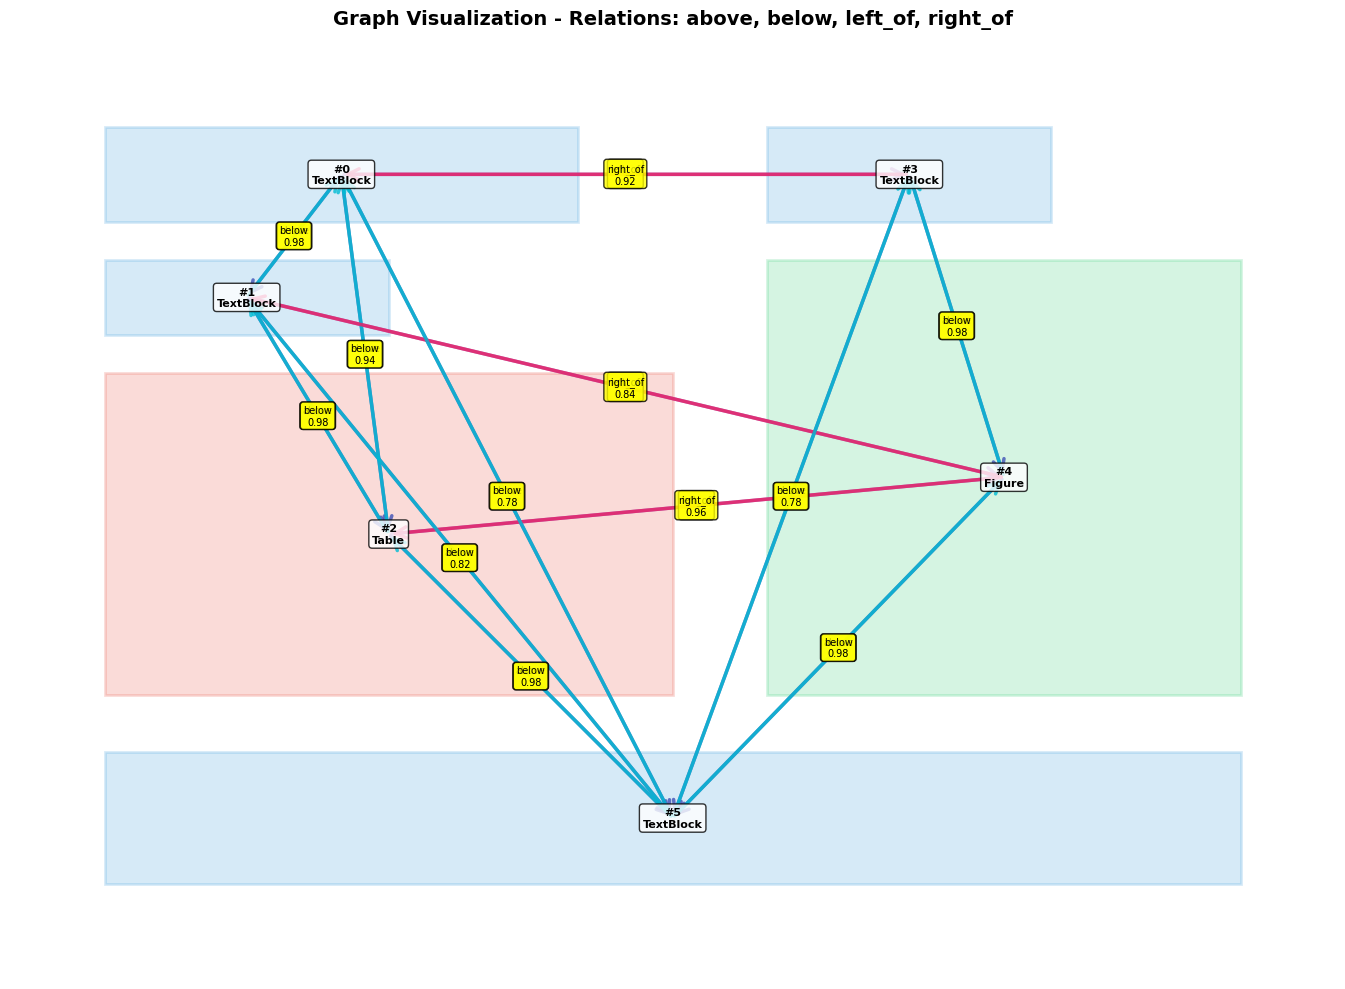

Showing 24 edges of type(s): ['above', 'below', 'left_of', 'right_of']


In [7]:
def visualize_by_relation_type(nodes, edges, relation_types, figsize=(14, 10)):
    """
    Visualize only specific relation types
    
    Args:
        nodes: List of node dicts from graph_result['nodes']
        edges: List of edge dicts from graph_result['edges']
        relation_types: List of relation types to display
    """
    filtered_edges = [e for e in edges if e['relation'] in relation_types]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate canvas size
    max_x = max_y = 0
    for node in nodes:
        bbox = node['bbox']
        x_coords = [p[0] for p in bbox]
        y_coords = [p[1] for p in bbox]
        max_x = max(max_x, max(x_coords))
        max_y = max(max_y, max(y_coords))
    
    ax.set_xlim(0, max_x + 50)
    ax.set_ylim(max_y + 50, 0)
    
    # Draw nodes
    for node in nodes:
        bbox = node['bbox']
        x_coords = [p[0] for p in bbox]
        y_coords = [p[1] for p in bbox]
        x1, y1 = min(x_coords), min(y_coords)
        x2, y2 = max(x_coords), max(y_coords)
        width = x2 - x1
        height = y2 - y1
        
        color = REGION_COLORS.get(node['region_type'], '#95a5a6')
        
        rect = Rectangle((x1, y1), width, height, 
                         linewidth=2, edgecolor=color, 
                         facecolor=color, alpha=0.2)
        ax.add_patch(rect)
        
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        ax.text(center_x, center_y, f"#{node['node_id']}\n{node['region_type']}", 
               ha='center', va='center', fontsize=8, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Draw filtered edges with labels
    for edge in filtered_edges:
        src_idx = edge['source']
        tgt_idx = edge['target']
        relation = edge['relation']
        score = edge['score']
        
        src_bbox = nodes[src_idx]['bbox']
        tgt_bbox = nodes[tgt_idx]['bbox']
        
        src_x = sum(p[0] for p in src_bbox) / 4
        src_y = sum(p[1] for p in src_bbox) / 4
        tgt_x = sum(p[0] for p in tgt_bbox) / 4
        tgt_y = sum(p[1] for p in tgt_bbox) / 4
        
        color = RELATION_COLORS.get(relation, '#34495e')
        
        arrow = FancyArrowPatch((src_x, src_y), (tgt_x, tgt_y),
                               arrowstyle='->', mutation_scale=20,
                               color=color, alpha=0.8, linewidth=2.5)
        ax.add_patch(arrow)
        
        # Add edge label
        mid_x = (src_x + tgt_x) / 2
        mid_y = (src_y + tgt_y) / 2
        ax.text(mid_x, mid_y, f"{relation}\n{score:.2f}", 
               fontsize=7, ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))
    
    ax.set_aspect('equal')
    title = f'Graph Visualization - Relations: {", ".join(relation_types)}'
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Showing {len(filtered_edges)} edges of type(s): {relation_types}")

# Example: Visualize only spatial relations
visualize_by_relation_type(nodes, edges, ['above', 'below', 'left_of', 'right_of'])

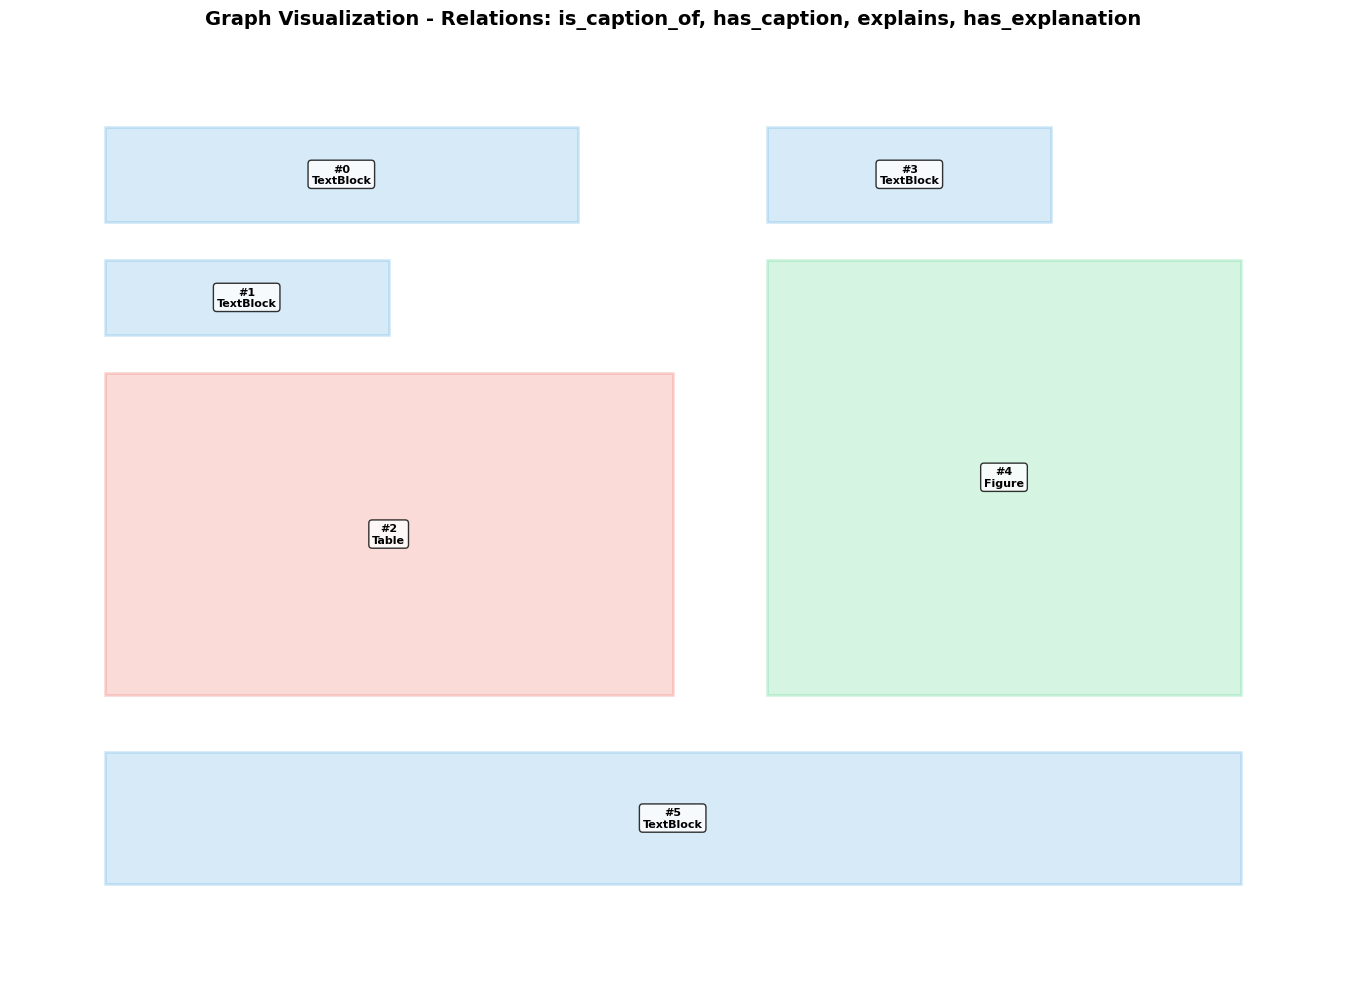

Showing 0 edges of type(s): ['is_caption_of', 'has_caption', 'explains', 'has_explanation']


In [8]:
# Example: Visualize only semantic relations (captions and explanations)
visualize_by_relation_type(nodes, edges, ['is_caption_of', 'has_caption', 'explains', 'has_explanation'])

### 5.3 Detailed Edge Information

In [9]:
def print_edge_details(nodes, edges, top_n=20):
    """
    Print detailed information about edges
    """
    print(f"\n{'='*80}")
    print(f"TOP {top_n} EDGES BY SCORE")
    print(f"{'='*80}\n")
    
    # Sort edges by score
    sorted_edges = sorted(edges, key=lambda x: x['score'], reverse=True)[:top_n]
    
    for i, edge in enumerate(sorted_edges, 1):
        src_idx = edge['source']
        tgt_idx = edge['target']
        relation = edge['relation']
        score = edge['score']
        category = edge.get('category', 'unknown')
        
        src_node = nodes[src_idx]
        tgt_node = nodes[tgt_idx]
        
        print(f"{i:2d}. [{relation}] Score: {score:.3f} ({category})")
        print(f"    Source #{src_idx} ({src_node['region_type']}): {src_node['text'][:50]}...")
        print(f"    Target #{tgt_idx} ({tgt_node['region_type']}): {tgt_node['text'][:50]}...")
        print()

print_edge_details(nodes, edges, top_n=15)


TOP 15 EDGES BY SCORE

 1. [above] Score: 0.984 (spatial)
    Source #0 (TextBlock): Document Title: Annual Report 2024...
    Target #1 (TextBlock): Table 1: Quarterly Sales Figures...

 2. [below] Score: 0.984 (spatial)
    Source #1 (TextBlock): Table 1: Quarterly Sales Figures...
    Target #0 (TextBlock): Document Title: Annual Report 2024...

 3. [above] Score: 0.984 (spatial)
    Source #1 (TextBlock): Table 1: Quarterly Sales Figures...
    Target #2 (Table): Q1: $1.2M | Q2: $1.5M | Q3: $1.8M | Q4: $2.1M...

 4. [below] Score: 0.984 (spatial)
    Source #2 (Table): Q1: $1.2M | Q2: $1.5M | Q3: $1.8M | Q4: $2.1M...
    Target #1 (TextBlock): Table 1: Quarterly Sales Figures...

 5. [above] Score: 0.984 (spatial)
    Source #3 (TextBlock): Figure 1: Sales Growth Chart...
    Target #4 (Figure): [Chart Image]...

 6. [below] Score: 0.984 (spatial)
    Source #4 (Figure): [Chart Image]...
    Target #3 (TextBlock): Figure 1: Sales Growth Chart...

 7. [above] Score: 0.976 (spatial)

## 6. Graph Statistics and Analysis

In [10]:
def analyze_graph_statistics(nodes, edges):
    """
    Compute and display various graph statistics
    """
    print(f"\n{'='*60}")
    print(f"GRAPH STATISTICS")
    print(f"{'='*60}\n")
    
    # Basic stats
    print(f"Number of Nodes: {len(nodes)}")
    print(f"Number of Edges: {len(edges)}")
    
    if len(edges) == 0:
        print("\n⚠️ No edges were generated. Check region data format.")
        return
    
    # Node degree statistics
    in_degree = {i: 0 for i in range(len(nodes))}
    out_degree = {i: 0 for i in range(len(nodes))}
    
    for edge in edges:
        out_degree[edge['source']] += 1
        in_degree[edge['target']] += 1
    
    avg_out_degree = sum(out_degree.values()) / len(nodes) if nodes else 0
    avg_in_degree = sum(in_degree.values()) / len(nodes) if nodes else 0
    
    print(f"\nDegree Statistics:")
    print(f"  Average Out-Degree: {avg_out_degree:.2f}")
    print(f"  Average In-Degree: {avg_in_degree:.2f}")
    print(f"  Max Out-Degree: {max(out_degree.values()) if out_degree else 0}")
    print(f"  Max In-Degree: {max(in_degree.values()) if in_degree else 0}")
    
    # Region type distribution
    type_counts = {}
    for node in nodes:
        rtype = node['region_type']
        type_counts[rtype] = type_counts.get(rtype, 0) + 1
    
    print(f"\nRegion Type Distribution:")
    for rtype, count in sorted(type_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {rtype:15s}: {count:3d} ({count/len(nodes)*100:.1f}%)")
    
    # Relation type distribution
    relation_counts = {}
    for edge in edges:
        rel = edge['relation']
        relation_counts[rel] = relation_counts.get(rel, 0) + 1
    
    print(f"\nRelation Type Distribution:")
    for rel, count in sorted(relation_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {rel:20s}: {count:3d} ({count/len(edges)*100:.1f}%)")
    
    # Score statistics
    scores = [e['score'] for e in edges]
    print(f"\nEdge Score Statistics:")
    print(f"  Mean Score: {np.mean(scores):.3f}")
    print(f"  Median Score: {np.median(scores):.3f}")
    print(f"  Min Score: {np.min(scores):.3f}")
    print(f"  Max Score: {np.max(scores):.3f}")
    print(f"  Std Dev: {np.std(scores):.3f}")
    
    print(f"\n{'='*60}\n")

analyze_graph_statistics(nodes, edges)


GRAPH STATISTICS

Number of Nodes: 6
Number of Edges: 27

Degree Statistics:
  Average Out-Degree: 4.50
  Average In-Degree: 4.50
  Max Out-Degree: 5
  Max In-Degree: 6

Region Type Distribution:
  TextBlock      :   4 (66.7%)
  Table          :   1 (16.7%)
  Figure         :   1 (16.7%)

Relation Type Distribution:
  above               :   9 (33.3%)
  below               :   9 (33.3%)
  left_of             :   3 (11.1%)
  nearest_neighbor    :   3 (11.1%)
  right_of            :   3 (11.1%)

Edge Score Statistics:
  Mean Score: 0.864
  Median Score: 0.936
  Min Score: 0.271
  Max Score: 0.984
  Std Dev: 0.162




## 7. Visualize Score Distribution

/tmp/ipykernel_14406/3606264105.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=box_labels, patch_artist=True)


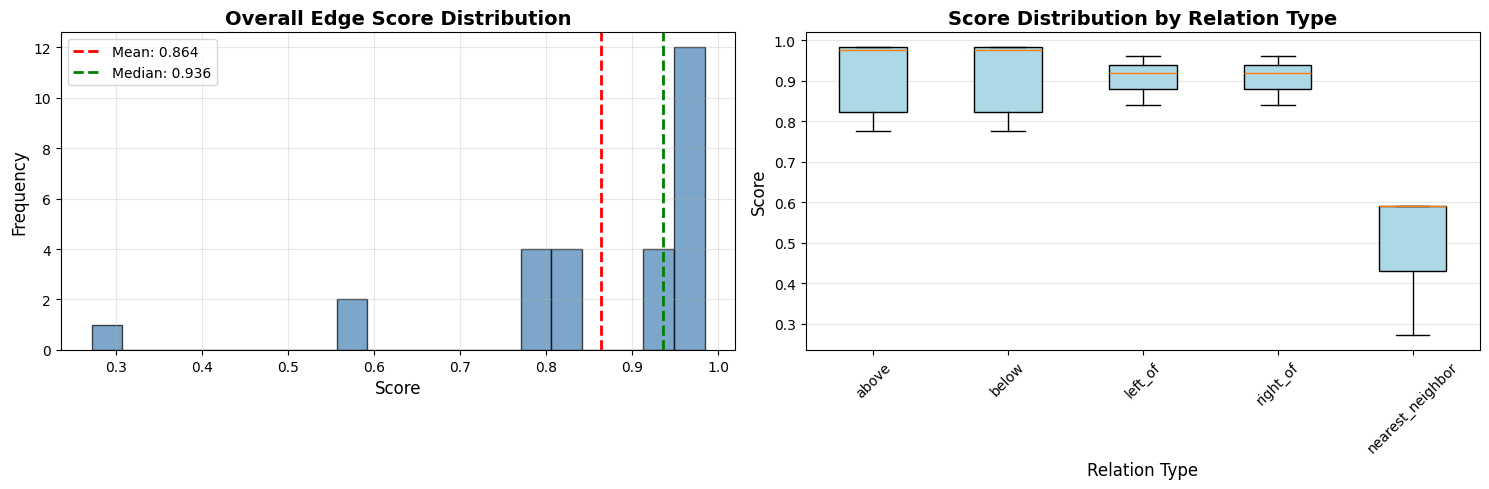

In [11]:
def plot_score_distributions(edges):
    """
    Plot score distributions for different relation types
    """
    if len(edges) == 0:
        print("⚠️ No edges to visualize.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Overall score distribution
    scores = [e['score'] for e in edges]
    axes[0].hist(scores, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(scores):.3f}')
    axes[0].axvline(np.median(scores), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(scores):.3f}')
    axes[0].set_xlabel('Score', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Overall Edge Score Distribution', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Score distribution by relation type
    relation_scores = {}
    for edge in edges:
        rel = edge['relation']
        if rel not in relation_scores:
            relation_scores[rel] = []
        relation_scores[rel].append(edge['score'])
    
    # Box plot (sorted by mean score)
    sorted_items = sorted(relation_scores.items(), key=lambda x: np.mean(x[1]), reverse=True)
    box_data = [scores for rel, scores in sorted_items]
    box_labels = [rel for rel, scores in sorted_items]
    
    if box_data:
        bp = axes[1].boxplot(box_data, labels=box_labels, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
    
    axes[1].set_xlabel('Relation Type', fontsize=12)
    axes[1].set_ylabel('Score', fontsize=12)
    axes[1].set_title('Score Distribution by Relation Type', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

plot_score_distributions(edges)

## 8. Export Graph to JSON

Save the graph structure for later use in GNN or QA systems

In [12]:
# Export graph to JSON (manually since we have the graph_result dict)
output_path = PROJECT_ROOT / "output" / "graph_visualization_output.json"
output_path.parent.mkdir(exist_ok=True)

from datetime import datetime

graph_data = {
    'version': '1.0.0',
    'created_at': datetime.now().isoformat(),
    'nodes': graph_result['nodes'],
    'edges': graph_result['edges'],
    'adjacency': graph_result['adjacency']
}

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(graph_data, f, indent=2, ensure_ascii=False)

print(f"✅ Graph exported to: {output_path}")
print(f"\nExported data structure:")
print(f"  - Nodes: {len(graph_data['nodes'])}")
print(f"  - Edges: {len(graph_data['edges'])}")
print(f"  - Adjacency entries: {len(graph_data['adjacency'])}")

✅ Graph exported to: /mnt/e/output/graph_visualization_output.json

Exported data structure:
  - Nodes: 6
  - Edges: 27
  - Adjacency entries: 6


## 9. Run on Real DocVQA Images (Optional)

Uncomment and run this cell to process a real image from your dataset

['../dataset/DocVQA_Images/train/10038.png']


Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.


Đang khởi tạo PaddleOCR engine...


/home/phn/working/.venv/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/phn/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/phn/.paddlex/official_models/PP-OCRv5_server_rec`.


-> PaddleOCR đã sẵn sàng!


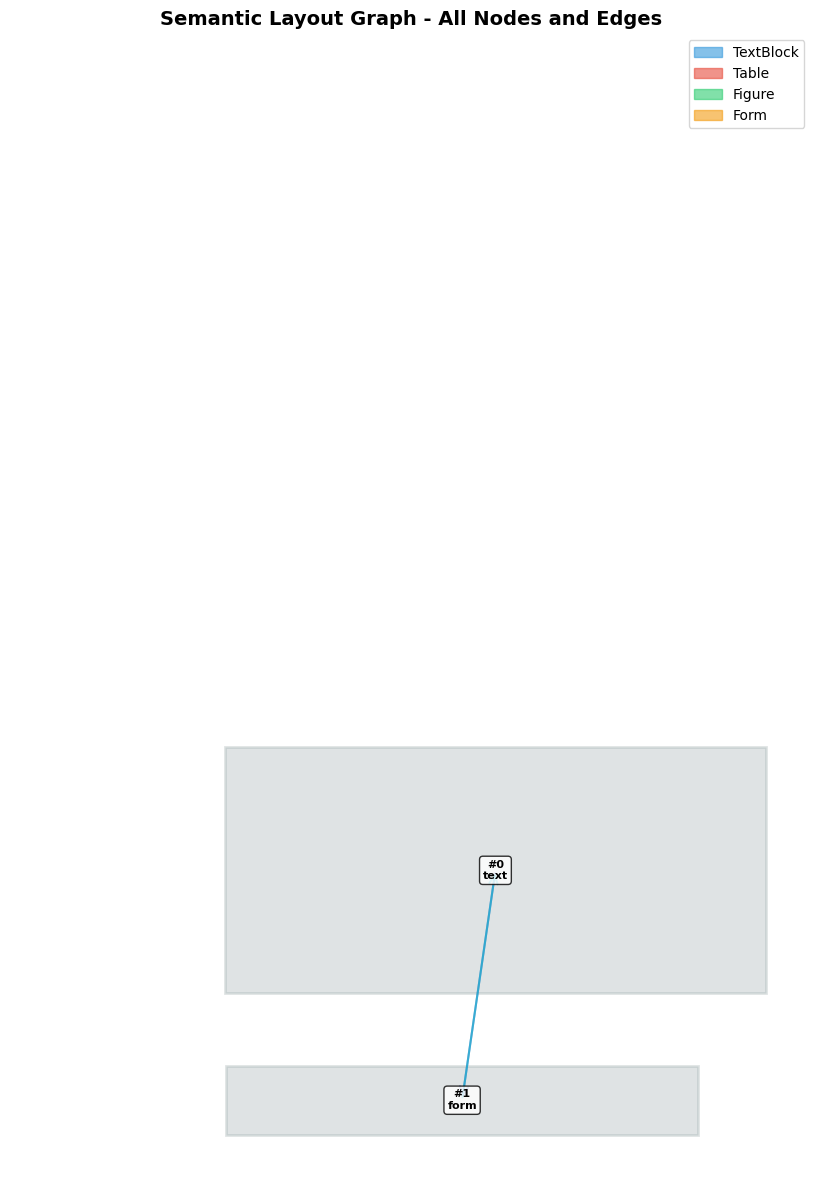

✅ Processed image: ../dataset/DocVQA_Images/train/10038.png
   Found 2 regions
   Generated 2 edges


In [13]:
import random

# Example: Process a real image from DocVQA dataset
sample_image = None
idx = random.randint(0, 1000)
if sample_image is None:
    for subset in SUBSETS:
        subset_folder = os.path.join(IMAGES_FOLDER, subset)
        if os.path.exists(subset_folder):
            images = glob.glob(os.path.join(subset_folder, "*.png"))[idx:idx+1]
            print(images)
            if images:
                sample_image = images[0]
                break
else:
    images = os.path.join(IMAGES_FOLDER, 'train', f'{sample_image}.png')

ocr_processor = PaddleOCRProcessor(
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=False
)
layout_analyzer = DocumentLayoutAnalyzer()
if sample_image != None:
    # Run OCR pipeline
    ocr_result = ocr_processor.run_ocr_with_layout(sample_image,
                                                use_preprocessing=True,
                                                max_size=2500)
    
    if ocr_result.get('success'):
        # Process with layout analyzer to get regions
        # (This depends on your layout_analyzer implementation)
        layout_result = layout_analyzer.analyze_layout(ocr_result)
        real_regions = layout_result.get('regions', [])
        
        # Build graph
        real_graph_result = graph_builder.build_graph(real_regions)
        
        # Visualize
        visualize_graph_basic(real_graph_result['nodes'], real_graph_result['edges'], figsize=(16, 12))
        
        print(f"✅ Processed image: {sample_image}")
        print(f"   Found {len(real_graph_result['nodes'])} regions")
        print(f"   Generated {len(real_graph_result['edges'])} edges")
    else:
        print(f"❌ OCR failed for image: {sample_image}")
else:
    print(f"⚠️ Image not found: {sample_image}")